# Graph Generation Rewrite

In [1]:
import os
import pickle as pkl
import pyrosetta as pr
from pyrosetta import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.core.pose import get_chain_from_chain_id, center_of_mass
from pyrosetta.rosetta.core.select.residue_selector import ChainSelector, \
ResidueIndexSelector, NeighborhoodResidueSelector
from pyrosetta.rosetta.core.select import get_residues_from_subset
import logging
import pandas as pd
import numpy as np
pr.init()


ModuleNotFoundError: No module named 'pyrosetta'

In [2]:
#preset
sfxn = get_fa_scorefxn()
classifier_path = "classifications/"
data_path = "../data" 
pdb_path = "crystal_structures"


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard res

In [ ]:
def parse_args():
    parser.add_argument("-o", "--output", help="Output name")
    parser.add_argument("-pr_path", "--protease_path", default = "", help="Path to silent pose directory for protease")
    parser.add_argument("-class", "--classification_file", default = "", help="Name of txt for sequences to use, must be in folder")
    parser.add_argument("-index_p1", "--index_p1", default = 7, help="Index of p1 in the pdb, starting from 1.")
    parser.add_argument("-prot", "--protease", default="HCV.pdb", help="Protease pdb name.")
    parser.add_argument("-d","--select_distance",default=10, help="Distance for NeighborSelector")
    return parser.parse_args()
    # parser.add_argument("-si", "--size_interface", help="|Interface|", type = int)
    # parser.add_argument("-is", "--interface_selector", help="Way Interface Is Selected, either k_nearest or residue_wise currently")
    # parser.add_argument("-unsafe", "--unsafe", help="Overwrite datasets", action='store_true')
    # parser.add_argument("-params", "--params", default = "", help= "parameters dict for the graphs")

In [ ]:
class_file = args.class
output = args.output
pr_path = args.protease_path
index_p1 = args.index_p1
protease = args.protease


In [5]:
def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    logger.info(filepath)
    with open(filepath, "r") as f:
        logger.info(f.read())

    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())

    return logger

In [ ]:
logger = get_logger(logpath=os.path.join(data_path, 'logs'), filepath=os.path.abspath(__file__))

In [ ]:
logger.info(params)

In [10]:
class_file = "sample.txt"

In [13]:
# Read in labels and sequences
try:
    df = pd.read_csv(os.path.join(classifier_path, class_file), sep = "\t")
    labels = list(df["Result"])
    sequences = list(df["Sequence"])
except:
    raise ValueError("Path either invalid to classsifications or not properly formatted. \
Please check template experimental_binary_classifications.txt")

In [14]:
df

,Sequence,Result
0,AYYYEPC.ASHL,CLEAVED


In [3]:
def get_silent_file(sequence, path_to_silent_files):
    """This just returns an absolute path to the silent file (windows specific possibly) false if not found"""
    silent_file = None
    for silent in os.listdir(path_to_silent_files):
        correct = True
        for counter, char in enumerate(silent):
            if char != sequence[counter] and char != "_":
                correct = False
                break
        if correct:
            silent_file = silent
            break
    if silent_file == None:
        print("Silent dir for {} not found in {}!".format(sequence, path_to_silent_files))
        return False
    silent_dir = os.path.join(path_to_silent_files, silent_file)
    silent_file_path = os.path.join(silent_dir, silent_file)
    
    if os.path.exists(silent_file_path):
        return silent_file_path
    else:
        print("Silent file for {} not found {}!".format(sequence, silent_file_path))
        return False

In [28]:
silent = get_silent_file("AYAKEPC.ASHL","silent")

In [29]:
silent

'silent/AYAK__C.ASHL/AYAK__C.ASHL'

In [5]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [4]:
def generate_dummy_silent(sequence, path_to_silent_files):
    silent_file = get_silent_file(sequence, path_to_silent_files)
    if not silent_file:
            return "Error: No Silent"
    with open(silent_file) as f:
        lineList = f.readlines()
    tag_ending = "substrate.{}".format(sequence)
    found, done = (False, False)
    ind, start, end, last_score = (0,0,0,0)
    while ind < len(lineList) and not done:
        x = lineList[ind]
        if "SCORE" in x:
            last_score = ind
        if not found and "ANNOTATED_SEQUENCE: " in x and tag_ending in x:
            start = last_score
            found = True
        elif found and "ANNOTATED_SEQUENCE: " in x:
            end = last_score
            done = True
        ind += 1
    if not found:
        print("The requested sequence {} was not found in the silent file {} (Parsing Error)".format(sequence, silent_file))
        raise ValueError("The requested sequence {} was not found in the silent file {} (Parsing Error)".format(sequence, silent_file))
    if not done:
        end = len(lineList)
    
    filename = sequence + str(np.random.randint(10000, 100000))
    path_bin = os.path.join(os.getcwd(), "bin")
    makedirs(path_bin)
    filename = os.path.join(path_bin, filename)
    with open(filename, "w") as f:
        # add header
        for i in range(3):
            f.write(lineList[i])
        # add binary information
        for i in range(start, end):
            f.write(lineList[i])
    return filename

In [6]:
filename = generate_dummy_silent("AYYYEPC.ASHL","silent")

In [8]:
filename

'/Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135'

In [7]:
for pose in poses_from_silent(filename):
    ret = pose

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135


In [43]:
ret

In [9]:
def get_pose_from_pdb(sequence, path):
    for pdb in os.listdir(path):
        if pdb == sequence:
            ret = pose_from_pdb(os.path.join(path, pdb))
    return ret

In [10]:
def get_pose(sequence, path, is_silent = True):
    if is_silent == True:
        try:
            filename = generate_dummy_silent(sequence, path)
            for pose in poses_from_silent(filename):
                ret = pose
            os.remove(filename)
            return ret
        except:
            return "Error: Invalid Silent"        
    else:
        ret = get_pose_from_pdb(sequence) # need to modify

In [11]:
pose = get_pose("AYYYEPC.ASHL","silent")

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL75824
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL75824


In [63]:
pose.dump_pdb("AYYYEPC.ASHL.pdb")

True

In [12]:
def index_substrate(pose):
    """Takes a pose and returns the indices of the substrate."""
    # get substrate with built in selector
    num_chains = pose.num_chains()
    chain_name = get_chain_from_chain_id(num_chains, pose)
    sub_sel = ChainSelector(chain_name)
    v1 = sub_sel.apply(pose)
    substrate_indices = []
    for count,ele in enumerate(v1):
        if ele:
            substrate_indices.append(count + 1)
    return substrate_indices

In [13]:
substrate_ind = index_substrate(pose)

In [14]:
substrate_ind

[197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]

In [15]:
index_p1 = "AYYYEPC.ASHL".index(".")
index_p1

7

In [16]:
def index_substrate_cut_site(pose, index_p1 = 7, upstream_buffer = 6, downstream_buffer = -1, protease = None):
    """This function takes the ROSETTA INDEX of the P1 residue for a substrate within its chain, a pose, and
    the number of upstream and downstream residues to model, and returns the indices of the substrate. If the
    buffer actually goes OOB of the substrate, a None type for that ind is instead returned for 0 pad modelling"""
    ind_sub = index_substrate(pose)
    ind_active = []
    for i in range(-upstream_buffer, downstream_buffer):
        index_interest = i + index_p1
        if index_interest < 0 or index_interest >= len(ind_sub):
            ind_active.append(None)
        else:
            ind_active.append(ind_sub[index_interest])
    return ind_active

In [17]:
#try
cutsite_ind = index_substrate_cut_site(pose)
cutsite_ind

[198, 199, 200, 201, 202]

In [18]:
def selector_to_list(pose, selector):
    """
    Produces a list of residues from a pose identified by a given selector
    """

    return list(get_residues_from_subset(selector.apply(pose)))

In [19]:
def index_interface(pose,
                    active_site,
                    substrate_indices,
                    d=10):
    """This function takes a pose and a number of interface/substrate to consider and returns interface indices. The
    value k and pose are not used..."""
    
    # Selection for neighbor residues
    focus_res = ','.join([str(j) for j in substrate_indices])
    focus_selector = ResidueIndexSelector(focus_res)

    interface = NeighborhoodResidueSelector()
    interface.set_focus_selector(focus_selector)
    interface.set_distance(d)
    interface.set_include_focus_in_subset(False)
    interface_indices = selector_to_list(pose, interface)
    interface_indices.sort()
            
    return interface_indices

In [79]:
# try
index_p1 = 7

In [91]:
sfxn.score(pose)

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.302067 seconds to load from binary


-483.2861533494107

In [20]:
hcv_pose = pose_from_pdb(os.path.join(pdb_path, "HCV.pdb"))
sfxn.score(hcv_pose)
interface_ind = index_interface(hcv_pose, cutsite_ind, substrate_ind, 10)

core.import_pose.import_pose: File 'crystal_structures/HCV.pdb' automatically determined to be of type PDB
basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.321671 seconds to load from binary


In [103]:
len(interface_ind)

44

In [23]:
def get_ind_from_protease(protease_name, pdb_path, index_p1, dis, sfxn):
    # load default pose as original
    pose = pose_from_pdb(os.path.join(pdb_path, protease_name))
    sfxn.score(pose)
    substrate_ind = index_substrate(pose) #the whole substrate
    cutsite_ind = index_substrate_cut_site(pose, index_p1) #p2-p6 on the substrate
    interface_ind = index_interface(pose, cutsite_ind, substrate_ind, dis)
    return cutsite_ind, interface_ind

In [24]:
#try
cutsite_ind, interface_ind = get_ind_from_protease("HCV.pdb", pdb_path, index_p1, 10, sfxn)


core.import_pose.import_pose: File 'crystal_structures/HCV.pdb' automatically determined to be of type PDB


In [130]:
','.join([str(u) for u in cutsite_ind])

'198,199,200,201,202'

In [109]:
pose.sequence()

'GSVVIVGRIILSGRGGPITAYAQQTRGLLGCIITSLTGRDKNQVEGEVQIVSTAAQTFLATCINGVCWTVYHGAGTRTIASPKGPVIQMYTNVDQDLVGWPASQGTRSLTPCTCGSSDLYLVTRHADVIPVRRRGDSRGSLLSPRPISYLKGSSGGPLLCPAGHAVGIFRAAVCTRGVAKAVDFIPVENLETTMRSAYYYEPCASHL'

In [108]:
print(center_of_mass(pose, 1, len(pose.sequence())))

      22.51380220451573      -23.18137728952420       40.13473036273557


In [116]:
class protein_graph:
    """This class is going to hold a graphical representation of a protein. It can be generated from two sources:
    a pose object, or the file path of a pdb. Since we are attempting to model a substrate/protein complex,
    the substrate and interface indices are ROSETTA(starting at 1) based indexes. When specified, these indices are
    the indices that are used as nodes. When not supplied, all indices are used. It is assumed that:
    
    The substrate's indices are the last in the pdb/pose
    When supplied interface and substrate are non-zero length
    The intersection of substrate and interface indices is empty
    Only canonical amino acids are not supported

    Possible Values:
    energy_terms = [fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref]
    energy_edge_terms = [pro_close, fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd]"""
    
    def __init__ (self, substrate_indices = None,
                  interface_indices = None,
                  pdb_file_path = None,
                  pose = None,
                  params = dict(),
                  sfxn = None):

        # assure user provided a source
        if pdb_file_path == None and pose == None:
            raise PathNotDeclaredError("No pose or pdb path provided")
        
        # make pose from pdb
        if pdb_file_path != None:
            try:
                cleanATOM(pdb_file_path)##### Need to fix this #####
                pose = pose_from_pdb(pdb_file_path)
            except:
                raise PathNotDeclaredError("Failed to generate pose, file path invalid or other issue")
        
        # if substrate or interface indices are given we will make vertice_arr specially tailored
        ls = substrate_indices + interface_indices
        vertice_arr = np.array(ls)
        interface_indices = np.array(interface_indices)
        substrate_indices = np.array(substrate_indices)
        
        # Get All Node Features
        if params["amino_acids"]: num_amino = 20
        else: num_amino = 0
        num_dim_sine = params["sinusoidal_encoding"]
        energy_terms = len(params["energy_terms"])
        if params["coordinates"]: num_coord = 3
        else: num_coord = 0
        
        # Make and Apply Score Function
        if sfxn == None: sfxn = get_fa_scorefxn()
        sfxn(pose)
        energies = pose.energies()
        
        # Determine N (number of residues)
        N = len(vertice_arr)
        
        # Determine F (number of node features)
        F = sum([num_amino, num_dim_sine, energy_terms, num_coord])
        if params["substrate_boolean"]: F += 1
        
        # Initialize V (Feature Tensor NxF)
        self.V = np.zeros(shape = (N, F))
        
        # Determine M (number of edge features)
        M = 0
#         if params["distance"]: M += 1
        M += len(params["energy_edge_terms"])
        if params["interface_edge"]: M += 1
        if params["covalent_edge"]: M += 1
        if params["hbond"]: M += 1
        # initialize A (Multiple Adj. Mat. NxNxM)
        self.A = np.zeros(shape = (N, N, M))
        counter_F = 0
        counter_M = 0

        # One Hot Vectors for Amino Acid Type
        if params["amino_acids"]:
            all_amino_acids = "ACDEFGHIKLMNPQRSTVWY"
            seq = pose.sequence()        
            # use the native ordering to generate features
            for i in range(len(vertice_arr)):
                i_ind = vertice_arr[i]
                if i_ind != None:
                    res = seq[i_ind - 1]
                    j = all_amino_acids.find(res)
                    self.V[i][j] = 1
            counter_F += 20
        
        # Sinusoidal Positional Encoding
        if num_dim_sine != 0:
            if not substrate_indices.any() and not interface_indices.any():
                n_position = N
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                self.V[0:n_position,counter_F:(counter_F + num_dim_sine)] = position_enc
            elif substrate_indices.any() and interface_indices.any():
                # add substrates
                n_position = len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                
                for i in range(len(substrate_indices)):
                    if substrate_indices[i] != None:
                        self.V[i, counter_F:(counter_F + num_dim_sine)] = position_enc[i, :]
                # add interface
                n_position = len(pose.sequence()) - len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                for i in range(N - len(substrate_indices)):
                    if interface_indices[i] != None:
                        self.V[(len(substrate_indices) + i), counter_F:(counter_F + num_dim_sine)] = position_enc[i, :]
            else:
                # add substrates
                n_position = len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in (substrate_indices - substrate_indices[0])])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                self.V[0:n_position,counter_F:(counter_F + num_dim_sine)] = position_enc
            counter_F += num_dim_sine

        # Single Body Energy Terms
        for counter, term in enumerate(params["energy_terms"], counter_F):
            for i in range(N):
                if vertice_arr[i] != None:
                    self.V[i, counter] = energies.residue_total_energies(vertice_arr[i])[term]
        counter_F += energy_terms

        if params["coordinates"]:
            for i in range(len(vertice_arr)):
                if vertice_arr[i] != None:
                    C_alpha_coord = to_numpy(pose.residue(vertice_arr[i]).xyz("CA"))
                    self.V[i, counter_F : (counter_F + 3)] = C_alpha_coord
            counter_F += 3
            print(self.V[i, counter_F : (counter_F + 3)])
        # New node feature
        """
        if params["new feature"]:
            self.V[:, counter_F] = whatever
            counter_F += 1
        """
        
        # Substrate boolean
        if params["substrate_boolean"]:
            self.V[0:len(substrate_indices),counter_F] = np.array([1 for x in range(len(substrate_indices))])

        # Total Two Body Energy and Energy Terms
        if len(params["energy_edge_terms"]) != 0:
            for i in range(len(vertice_arr)):
                for j in range(i, len(vertice_arr)):
                    if vertice_arr[i] != None and vertice_arr[j] != None:
                        if i != j:
                            rsd1 = pose.residue(vertice_arr[i])
                            rsd2 = pose.residue(vertice_arr[j])
                            emap = EMapVector()
                            sfxn.eval_ci_2b(rsd1, rsd2, pose, emap)
                            for counter, term in enumerate(params["energy_edge_terms"]):
                                self.A[i, j, counter_M + counter] = emap[term]
                                self.A[j, i, counter_M + counter] = emap[term]
            counter_M += len(params["energy_edge_terms"])

        # Hydrogen Bonding Energies
        if params["hbond"]:
            hbs=pose.get_hbonds()
            res_dict = dict()
            for res in vertice_arr:
                hbl = hbs.residue_hbonds(res)
                for hb in hbl:
                    residues = (hb.don_res(), hb.acc_res())
                    if residues[0] > residues[1]: residues = (hb.acc_res(), hb.don_res())
                    if residues[0] in vertice_arr and residues[1] in vertice_arr: res_dict[residues] = hb.energy()
            for residues in res_dict:
                for i in np.where(vertice_arr==residues[0])[0]:
                    for j in np.where(vertice_arr==residues[1])[0]:
                        self.A[i,j,counter_M] += self.A[i,j,counter_M] + res_dict[residues]
                        self.A[j,i,counter_M] += self.A[j,i,counter_M] + res_dict[residues]
            counter_M += 1

        # Protease - Substrate Interactions Boolean
        if params["interface_edge"]:
            self.A[0:len(substrate_indices), len(substrate_indices):len(vertice_arr), counter_M] = 1
            self.A[len(substrate_indices):len(vertice_arr), 0:len(substrate_indices), counter_M] = 1
            counter_M += 1

        # Covalent Bond Connection Boolean
        if params["covalent_edge"]:
            for i in range(len(vertice_arr) - 1):
                if vertice_arr[i + 1] - vertice_arr[i] == 1:
                    self.A[i, i + 1, counter_M] = 1
                    self.A[i + 1, i, counter_M] = 1
            counter_M += 1
        print(vertice_arr)

In [122]:
# Goes from a sequence to a graph representation.
def generate_graph(seq, pr_path, substrate_ind, interface_ind, params, sfxn):
    pose = get_pose(seq, pr_path)
    if type(pose) == type("string"):
        return pose
    g = protein_graph(pose = pose,
                       substrate_indices = cutsite_ind,
                       interface_indices = interface_ind,
                       sfxn = sfxn,
                       params = params)
    return g

In [124]:
gg =generate_graph("AYYYEPC.ASHL","silent",substrate_ind,interface_ind,params,sfxn)

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL54063
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL54063
[198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73
  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183]


In [117]:
params = {"amino_acids":True,
                "sinusoidal_encoding":2,
#                 "cosine_similarity":False,
                "coordinates": False,
                "substrate_boolean":True,
                "energy_terms":[fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref],
                "energy_edge_terms":[fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd],
                "hbond": True,
                "interface_edge": True,
                "covalent_edge": True,
#                 "distance":True,
#                 "energy":True
         }

In [118]:
g = protein_graph(pose = pose,
                       substrate_indices = cutsite_ind,
                       interface_indices = interface_ind,
                       sfxn = sfxn,
                       params = params)

[198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73
  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183]


In [126]:
gg.V[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.24161177,  4.16952966, -0.49597924,
        0.02561926,  0.09068901,  3.8212185 ,  0.58223   ,  1.        ])

In [32]:
g.V.shape, g.A.shape

((49, 30), (49, 49, 10))

In [41]:
columns = ["aa1","aa2","aa3","aa4","aa5","aa6","aa7","aa8","aa9","aa10",
          "aa11","aa12","aa13","aa14","aa15","aa16","aa17","aa18","aa19","aa20",
          "sin1","sin2","fa_intra_sol_xover4", "fa_intra_rep", "rama_prepro", 
           "omega", "p_aa_pp", "fa_dun", "ref","is_substrate"]

In [42]:
df = pd.DataFrame(g.V, columns = columns)

In [49]:
df.iloc[0,19]

1.0

In [51]:
df.head()

,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,...,sin1,sin2,fa_intra_sol_xover4,fa_intra_rep,rama_prepro,omega,p_aa_pp,fa_dun,ref,is_substrate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.241612,4.169530,-0.495979,0.025619,0.090689,3.821219,0.58223,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.841471,1.0,0.268187,4.235788,0.959456,1.152130,-0.566650,2.408025,0.58223,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909297,1.0,0.286675,4.379675,1.205627,-0.092665,0.053928,4.067401,0.58223,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141120,1.0,0.297897,1.398956,1.115776,-0.055925,0.326248,4.119510,-2.72453,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.756802,1.0,0.116397,0.797717,0.684848,1.322425,-1.481414,0.895828,-1.64321,1.0


In [119]:
columns=["fa_atr", "fa_rep", "fa_sol", "fa_elec", "lk_ball_wtd", "hbond",
        "link_interface_substrate","is_covalent"]
df_edge = pd.DataFrame(g.A[1], columns = columns)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2401.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-0.5  , -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 , -0.325,
        -0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
        -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
         0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,  0.425,  0.45 ,  0.475,
         0.5  ]),
 <a list of 40 Patch objects>)

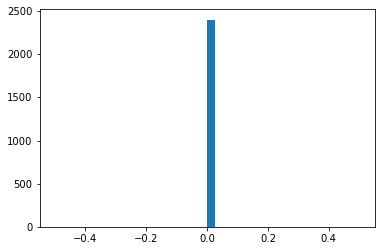

In [80]:
import matplotlib.pyplot as plt
plt.hist(g.A[:,:,5].flatten(),bins=40)

In [ ]:
#pro_close, hbond_sc = 0?

In [68]:
sum(g.A[:,:,7].flatten()!=0)

66

In [69]:
np.where(g.A[:,:,7]!=0)

(array([ 1,  3,  3,  5,  6,  7,  7,  7,  8,  9,  9,  9, 10, 11, 12, 12, 13,
        13, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 19, 20, 20, 20, 22, 22,
        22, 23, 24, 24, 27, 28, 28, 29, 30, 30, 30, 31, 32, 33, 33, 34, 34,
        35, 35, 36, 37, 38, 38, 39, 40, 42, 43, 45, 46, 48, 48, 48]),
 array([39, 28, 37, 11,  7,  6,  8,  9,  7,  7, 16, 17, 22,  5, 13, 31, 12,
        14, 13, 17, 18, 19, 20,  9, 20,  9, 14, 14, 15, 15, 16, 35, 10, 29,
        30, 48, 28, 42, 30,  3, 24, 22, 22, 27, 33, 12, 34, 30, 34, 32, 33,
        20, 48, 48,  3, 45, 46,  1, 43, 24, 40, 38, 38, 23, 35, 36]))

In [81]:
hbs=pose.get_hbonds()


In [95]:
vertice_arr = "198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183".split(" ")
while '' in vertice_arr:
    vertice_arr.pop(vertice_arr.index(''))
vertice_arr = [int(x) for x in vertice_arr]


In [110]:
for hb in hbs.residue_hbonds(199):
    print(hb)
    print(hb.don_res(),hb.acc_res())

9 don: protein backbone 174 7 acc: protein backbone 199 4 -1.38681 1

174 199


In [ ]:
def main(args):
    #preset
    pr.init()
    sfxn = get_fa_scorefxn()
    classifier_path = "classifications/"
    data_path = "../data" 
    pdb_path = "crystal_structures"
    
    class_file = args.class #list of samples
    output = args.output 
    pr_path = args.protease_path
    index_p1 = args.index_p1
    protease = args.protease
    dis = args.select_sequence
    
    logger = get_logger(logpath=os.path.join(data_path, 'logs'), filepath=os.path.abspath(__file__))
    
    params = {"amino_acids":True,
                "sinusoidal_encoding":2,
                "coordinates": False,
                "substrate_boolean":True,
                "energy_terms":[fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref],
                "energy_edge_terms":[fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd],
                "hbond": True,
                "interface_edge": True,
                "covalent_edge": True,}
    logger.info("Features Info: {}".format(params))
    
    cutsite_ind, interface_ind = get_ind_from_protease(args.protease, pdb_path, index_p1, d, sfxn)
    logger.info("Focus substrate indices are {}".format(','.join(cutsite_ind)))
    logger.info("Neighbor residues indices are {}".format(','.join(interface_ind)))
    
    # Read in labels and sequences
    try:
        df = pd.read_csv(os.path.join(classifier_path, class_file), sep = "\t")
        labels = list(df["Result"])
        sequences = list(df["Sequence"])
    except:
        raise ValueError("Path either invalid to classsifications or not properly formatted. \
    Please check template sample.txt")
    
    # get all graphs into a list
    missed_sequences = []
    error_sequences = []
    seq_final = []
    label_final = []
    graphs = []
    for i in range(len(sequences)):
        seq = sequences[i]
        graph = generate_graph(seq, pr_path, cutsite_ind, interface_ind)
        logger.info("Graph for {} has been generated successfully.".format(seq))
        if graph == "Error: No Silent":
            missed_sequences.append(seq)
        elif graph == "Error: Invalid Silent":
            error_sequences.append(seq)
        else:
            seq_final.append(seq)
            graphs.append(graph)
            label_final.append(labels[i])
    
    logger.info("There were {} poses which loaded".format(len(graphs)))
    logger.info("There were {} poses missing due to silent files.".format(len(missed_sequences)))
    logger.info("There were {} poses which failed to be loaded.".format(len(error_sequences)))
    
if __name__ == '__main__':
    args = parse_args()
    main(args)    

In [131]:
x = pkl.load(open(os.path.join(data_path, "ind.sample.x"),"rb"))
y = pkl.load(open(os.path.join(data_path, "ind.sample.y"),"rb"))
graph = pkl.load(open(os.path.join(data_path,"ind.sample.graph"),"rb"))
labelorder = pkl.load(open(os.path.join(data_path,"ind.sample.labelorder"),"rb"))
sequences = pkl.load(open(os.path.join(data_path,"ind.sample.sequences"),"rb"))

In [149]:
y

array([[1]])

# Import data and Transformation

In [1]:
import pickle as pkl
graph = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.graph","rb"))
x = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.x","rb"))
y = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.y","rb"))
sequences = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.sequences","rb"))
labelorder = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.labelorder","rb"))


In [159]:
x.shape, y.shape, len(sequences), graph.shape

((7342, 34, 30), (7342, 2), 7342, (7342, 34, 34, 8))

In [161]:
labelorder

['CLEAVED', 'UNCLEAVED']

In [127]:
lis = [22,23,24]
features.numpy()[...,lis].shape

(7342, 34, 3)

In [135]:
tmp = features.numpy().copy()
tmp[...,lis] = np.exp(-tmp[...,lis])


In [148]:
features[0,:,22]

tensor([0.2416, 0.2682, 0.2867, 0.2979, 0.1164, 0.4488, 0.0388, 0.7256, 0.0000,
        0.7690, 0.7373, 0.1302, 0.0930, 0.2102, 0.0000, 0.0260, 0.2767, 0.0000,
        0.0000, 0.0400, 0.0452, 0.0571, 0.2590, 0.0000, 0.0496, 0.0000, 0.1314,
        0.0000, 0.0512, 0.2857, 0.0000, 0.0163, 0.0000, 0.0308])

In [137]:
tmp[0,:,22]

array([0.785361  , 0.764765  , 0.7507559 , 0.7423777 , 0.8901221 ,
       0.63842046, 0.9619834 , 0.4840394 , 1.        , 0.46346763,
       0.47838128, 0.87791383, 0.91121656, 0.8104091 , 1.        ,
       0.9743129 , 0.7582452 , 1.        , 1.        , 0.96078444,
       0.9557751 , 0.944509  , 0.77181405, 1.        , 0.9515775 ,
       1.        , 0.87682766, 1.        , 0.9500952 , 0.75145054,
       1.        , 0.9838514 , 1.        , 0.96968603], dtype=float32)

In [146]:
# exp(-x) for features
def transform(mat, ind = 'all'): # ind saves indices that needs to be transformed, like '(22,29)'
    try:
        mat = mat.numpy().copy()
    except AttributeError:
        pass
    if ind == 'all':
        return np.exp(-mat)
    else:
        ind_ends = [int(x) for x in ind.strip('()').split(',')]
        ind_list = np.arange(ind_ends[0],ind_ends[1])
        mat[...,ind_list] = np.exp(-mat[...,ind_list])
    return mat

In [149]:
tmp = transform(features,ind='(-8,-1)')
tmp[0,:,22]

array([0.785361  , 0.764765  , 0.7507559 , 0.7423777 , 0.8901221 ,
       0.63842046, 0.9619834 , 0.4840394 , 1.        , 0.46346763,
       0.47838128, 0.87791383, 0.91121656, 0.8104091 , 1.        ,
       0.9743129 , 0.7582452 , 1.        , 1.        , 0.96078444,
       0.9557751 , 0.944509  , 0.77181405, 1.        , 0.9515775 ,
       1.        , 0.87682766, 1.        , 0.9500952 , 0.75145054,
       1.        , 0.9838514 , 1.        , 0.96968603], dtype=float32)

In [150]:
adj_ls.shape

torch.Size([7342, 34, 34, 8])

In [ ]:
tmp = transform(adj_ls,ind='(-8,-1)')

In [159]:
# edge
tmp1 = transform(adj_ls, ind='(0,6)')


In [158]:
adj_ls[0,4,6,:]

tensor([-3.5018e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00])

In [160]:
tmp1[0,4,6,:]

array([1.0003502, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 0.       ], dtype=float32)

# Feature distribution

In [14]:
columns = ["aa1","aa2","aa3","aa4","aa5","aa6","aa7","aa8","aa9","aa10",
          "aa11","aa12","aa13","aa14","aa15","aa16","aa17","aa18","aa19","aa20",
          "sin1","sin2","fa_intra_sol_xover4", "fa_intra_rep", "rama_prepro", 
           "omega", "p_aa_pp", "fa_dun", "ref","is_substrate"]
df = pd.DataFrame(features.numpy()[0], columns = columns)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([22026.,  7342.,     0.,  7342., 14684.,  7342.,     0.,     0.,
            0., 14684.,     0.,     0.,     0.,     0., 14684.,     0.,
            0.,  7342.,     0.,  7342., 14684.,     0., 14684.,  7342.,
            0.,  7342.,     0.,     0., 14684.,     0.,     0.,     0.,
            0., 14684.,     0.,  7342.,  7342., 14684., 22026., 22026.]),
 array([-0.9999902 , -0.9502253 , -0.90046036, -0.85069543, -0.80093044,
        -0.7511655 , -0.7014006 , -0.65163565, -0.6018707 , -0.5521058 ,
        -0.5023408 , -0.4525759 , -0.40281093, -0.353046  , -0.30328107,
        -0.25351614, -0.20375118, -0.15398625, -0.1042213 , -0.05445636,
        -0.00469142,  0.04507352,  0.09483846,  0.1446034 ,  0.19436833,
         0.24413328,  0.29389822,  0.34366316,  0.3934281 ,  0.44319305,
         0.49295798,  0.54272294,  0.5924879 ,  0.6422528 ,  0.69201773,
         0.74178267,  0.7915476 ,  0.8413126 ,  0.8910775 ,  0.94084245,
         0.9906074 ], dtype=float32),
 <a list of 40 P

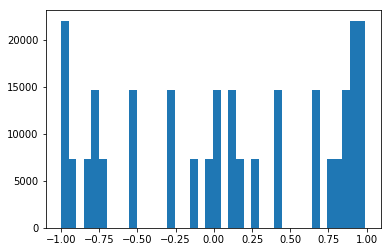

In [27]:
# sinusoidal encoding
plt.hist(features[:,:,20].flatten(),bins=40)

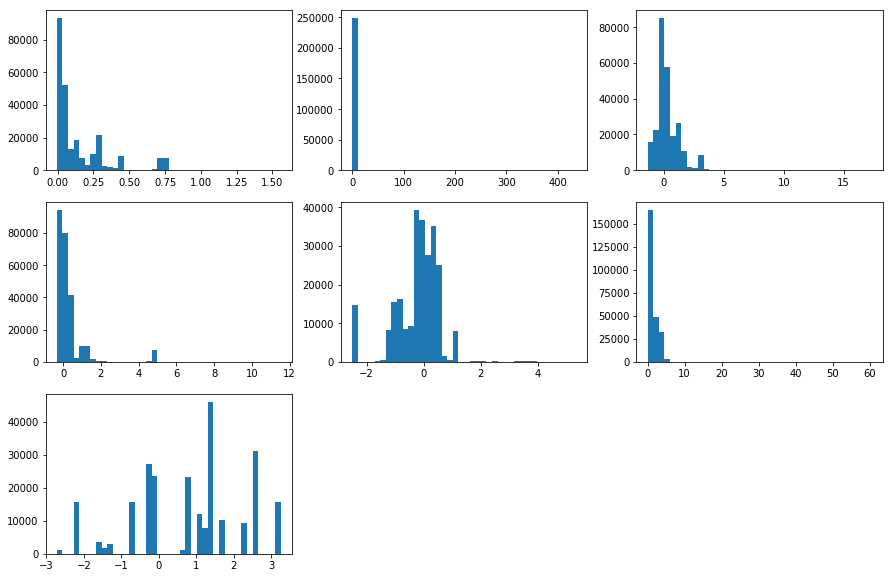

In [25]:
plt.figure(figsize=(15,10))
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.hist(features[:,:,i+21].flatten(),bins=40)

(0, 50)

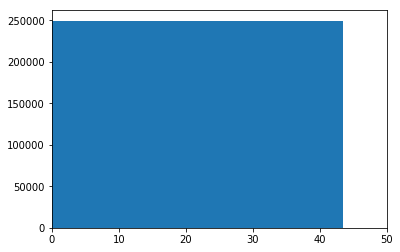

In [20]:
#fa_intra_rep
plt.hist(features[:,:,23].flatten())
plt.xlim((0,50))

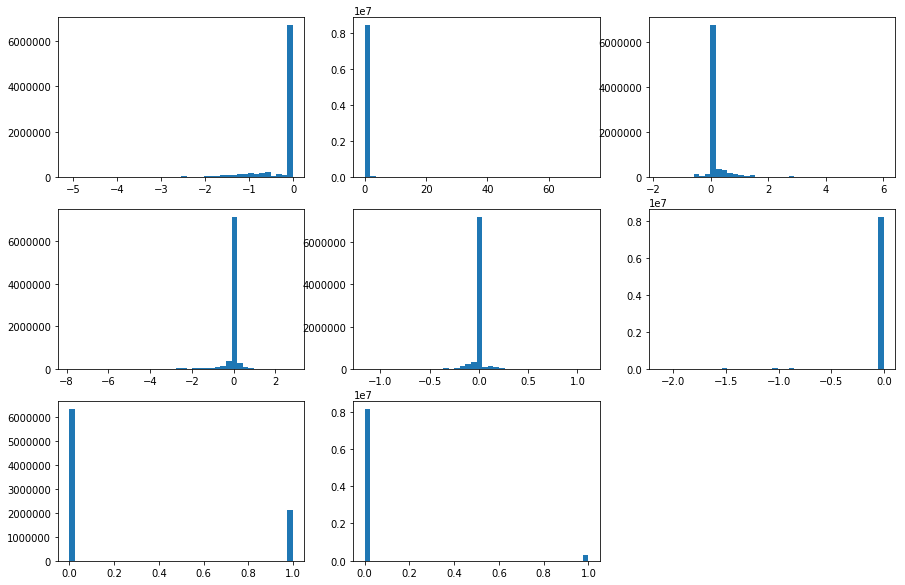

In [152]:
# edge_features
edge_columns = ["fa_atr", "fa_rep", "fa_sol", "fa_elec", "lk_ball_wtd", "hbond", "is_interface", "covalent_bond"]
plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.hist(adj_ls[:,:,:,i-1].flatten(),bins=40)

# Features distribution after transformation

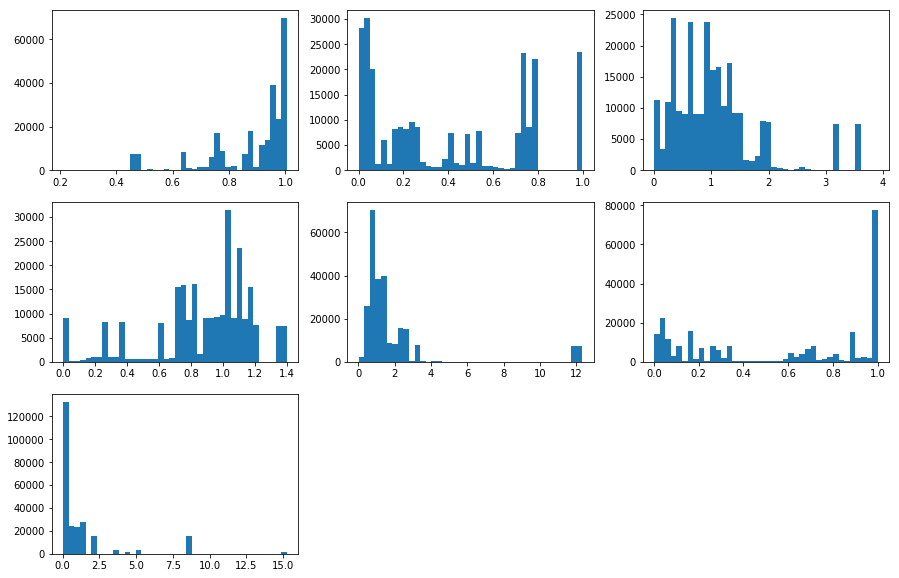

In [153]:
#node features
plt.figure(figsize=(15,10))
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.hist(tmp[:,:,i+21].flatten(),bins=40)

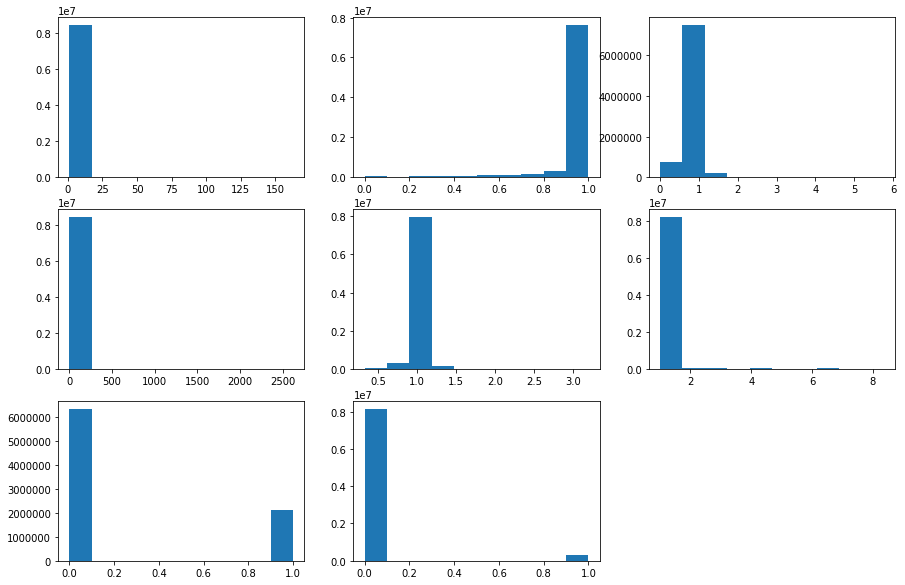

In [164]:
#edge
plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.hist(tmp1[:,:,:,i-1].flatten())

# normalize part

In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp

In [5]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)
def load_data(dataset_str, is_test=None, norm_type=False, protease="HCV"):
    protease = protease
    names = ['x', 'y', 'graph', 'sequences', 'labelorder']
    objects = []
    for i in range(len(names)):
        with open("../data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    features, y_arr, adj_ls, sequences, labelorder = tuple(objects)
    proteases = [protease for x in sequences]
    # turn edges into nodes
    # node feature matrix

    # Split all datasets into testing, training, and validation. The split of this data is fixed for each dataset
    # because the numpy seed is fixed, currently the breakdown is train: 60, validation: 10, test: 30
    idx = [y_ind for y_ind in range(y_arr.shape[0])]
    np.random.shuffle(idx)
    cutoff_1 = int(6*len(idx)/10)
    cutoff_2 = int(7*len(idx)/10)
    idx_train = idx[:cutoff_1]
    idx_val = idx[cutoff_1:cutoff_2]
    idx_test = idx[cutoff_2:]
    idx_train, idx_val, idx_test = np.sort(idx_train), np.sort(idx_val), np.sort(idx_test)
    # make logical indices (they are the size BATCH)
    train_mask = sample_mask(idx_train, y_arr.shape[0])
    val_mask = sample_mask(idx_val, y_arr.shape[0])
    test_mask = sample_mask(idx_test, y_arr.shape[0])

    if is_test != None:
        test_idx_reorder = parse_index_file("../data/ind.{}.test.index".format(is_test))
        test_idx_range = np.sort(test_idx_reorder)
        test_mask = np.zeros(len(train_mask), dtype=np.bool)
        test_mask[test_idx_range] = True
        # make train test split
        tmp_mask = test_mask.copy()
        train_mask = np.array([(not idx) for idx in test_mask],dtype=np.bool)
        
        train_ind = set(range(len(train_mask))) - set(test_idx_range)
        val_ind = np.random.choice(list(train_ind), int(len(train_mask)*0.1),replace=False)
        
        val_mask = np.zeros(len(train_mask), dtype=np.bool)
        val_mask[val_ind] = True
        tmp_mask[val_ind] = True
        train_mask = np.array([(not idx) for idx in tmp_mask], dtype=np.bool)

#     adj_ls = normalize(adj_ls, norm_type)
    features = transform(features,ind='(-8,-1)') #only energy features
    adj_ls = transform(adj_ls, ind='(0,6)') # only energy features
    
    features = torch.FloatTensor(np.array(features))
    y_arr = torch.LongTensor(y_arr)
    adj_ls = torch.FloatTensor(np.array(adj_ls))

    return adj_ls, features, y_arr, sequences, proteases, labelorder, train_mask, val_mask, test_mask

In [145]:
adj_ls, features, labels, sequences, proteases, labelorder, train_mask, val_mask, test_mask = load_data("HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond", is_test=None, norm_type=False,protease="HCV")


In [8]:
adj_ls.shape, features.shape

(torch.Size([7342, 34, 34, 8]), torch.Size([7342, 34, 30]))

In [27]:
columns = ["aa1","aa2","aa3","aa4","aa5","aa6","aa7","aa8","aa9","aa10",
          "aa11","aa12","aa13","aa14","aa15","aa16","aa17","aa18","aa19","aa20",
          "sin1","sin2","fa_intra_sol_xover4", "fa_intra_rep", "rama_prepro", 
           "omega", "p_aa_pp", "fa_dun", "ref","is_substrate"]
df = pd.DataFrame(features.numpy()[0], columns = columns)

In [29]:
df.head()

,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,...,sin1,sin2,fa_intra_sol_xover4,fa_intra_rep,rama_prepro,omega,p_aa_pp,fa_dun,ref,is_substrate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.241612,4.169529,-0.495979,0.025619,0.090689,3.821218,0.58223,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.841471,1.0,0.268187,4.235788,0.959456,1.152130,-0.566650,2.408025,0.58223,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909297,1.0,0.286675,4.379674,1.205627,-0.092665,0.053928,4.067401,0.58223,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141120,1.0,0.297897,1.398956,1.115776,-0.055925,0.326248,4.119510,-2.72453,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.756802,1.0,0.116397,0.797717,0.684848,1.322425,-1.481413,0.895828,-1.64321,1.0


In [184]:
def normalize(mx):  
    # normalize matrix using partition probability because weights * features should avoid features = 0
    # but distribution range is small
    # so just do exp(-x) in transformation and then normalize edge using row normalization
    try:
        mat = mat.numpy().copy()
    except AttributeError:
        pass
    for b in range(mx.shape[0]):
        for m in range(mx.shape[3]):
            mx[b][:,:,m] += np.eye(mx.shape[1])
    rowsum = np.array(mx.sum(2)) # Here starts to multiply -1/2 degree matrix on both sides of transformed adjacency matrix
    r_inv = np.power(rowsum, -0.5)
    r_inv[np.isinf(r_inv)] = 0.
    for b in range(mx.shape[0]):
        for m in range(mx.shape[3]):
            r_mat_inv = sp.diags(r_inv[b,:,m])
            mx[b,:,:,m] = r_mat_inv * mx[b,:,:,m] * r_mat_inv
    return mx

In [181]:
rowsum = np.array(tmp11.sum(2))
rowsum.shape

(7342, 34, 8)

In [183]:
np.sum(tmp11[0,0,:,0])

0.96877426

In [182]:
rowsum[0,0,0]

0.9687742

In [171]:
tmp11 = normalize(tmp1)

In [116]:
features[0]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  3.8212,  0.5822,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4080,  0.5822,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  4.0674,  0.5822,  1.0000],
        ...,
        [ 0.0000,  1.0000,  0.0000,  ...,  0.4410,  3.2548,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.3247,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.3211, -0.2897,  0.0000]])

In [50]:
exp_mat = np.exp(-features.numpy())

In [51]:
exp_mat[0]

array([[1.        , 1.        , 1.        , ..., 0.0219011 , 0.5586512 ,
        0.36787945],
       [1.        , 1.        , 1.        , ..., 0.08999287, 0.5586512 ,
        0.36787945],
       [1.        , 1.        , 1.        , ..., 0.01712182, 0.5586512 ,
        0.36787945],
       ...,
       [1.        , 0.36787945, 1.        , ..., 0.6433931 , 0.03858892,
        1.        ],
       [0.36787945, 1.        , 1.        , ..., 1.        , 0.26588804,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.7253423 , 1.3360132 ,
        1.        ]], dtype=float32)

In [52]:
tmp = np.sum(exp_mat,axis=0)
tmp.shape

(34, 30)

In [53]:
np.sum(exp_mat[:,0,1]),tmp[0,1]

(7180.8096, 7180.7686)

In [54]:
tmp1 = exp_mat / tmp
tmp1.shape

(7342, 34, 30)

In [55]:
exp_mat[0,0,1] / tmp[0,1],tmp1[0,0,1]

(0.00013926085, 0.00013926085)

In [56]:
exp_mat[353,3,2] / tmp[3,2], tmp1[353,3,2]

(0.00013831067, 0.00013831067)

In [70]:
tmp = features.numpy() - np.mean(features.numpy(), axis=0)
tmp.shape

(7342, 34, 30)

In [108]:
np.max(exp_mat, axis=0)

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
        15.249245  ,  0.36787945],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
        15.249245  ,  0.36787945],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
        15.249245  ,  0.36787945],
       ...,
       [ 1.        ,  0.36787945,  1.        , ...,  0.74320847,
         0.03858892,  1.        ],
       [ 0.36787945,  1.        ,  1.        , ...,  1.        ,
         0.26588804,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  0.7253569 ,
         1.3360132 ,  1.        ]], dtype=float32)

In [111]:
np.min(exp_mat, axis=0)

array([[3.6787945e-01, 3.6787945e-01, 3.6787945e-01, ..., 1.5723297e-03,
        3.8588922e-02, 3.6787945e-01],
       [3.6787945e-01, 3.6787945e-01, 3.6787945e-01, ..., 1.8294515e-04,
        3.8588922e-02, 3.6787945e-01],
       [3.6787945e-01, 3.6787945e-01, 3.6787945e-01, ..., 4.9703369e-10,
        3.8588922e-02, 3.6787945e-01],
       ...,
       [1.0000000e+00, 3.6787945e-01, 1.0000000e+00, ..., 4.8745534e-01,
        3.8588922e-02, 1.0000000e+00],
       [3.6787945e-01, 1.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        2.6588804e-01, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.0639664e-01,
        1.3360132e+00, 1.0000000e+00]], dtype=float32)

(array([   0.,    0.,    0.,    0.,    0., 7342.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

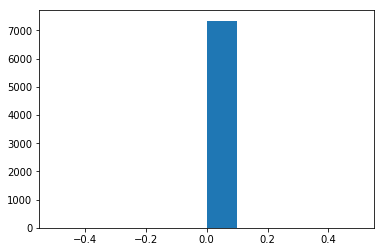

In [114]:
plt.hist(features[:,33,29].flatten())

In [87]:
features.shape

torch.Size([7342, 34, 30])

In [99]:
norm_mat = normalize(features)
norm_mat.shape

/Users/cplu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/cplu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(7342, 34, 30)

In [101]:
norm_mat[0,0,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
              nan,        nan, 0.68271136, 0.01526785, 0.6725153 ,
       0.7518928 , 0.16327068, 0.02036078, 0.03419065,        nan],
      dtype=float32)

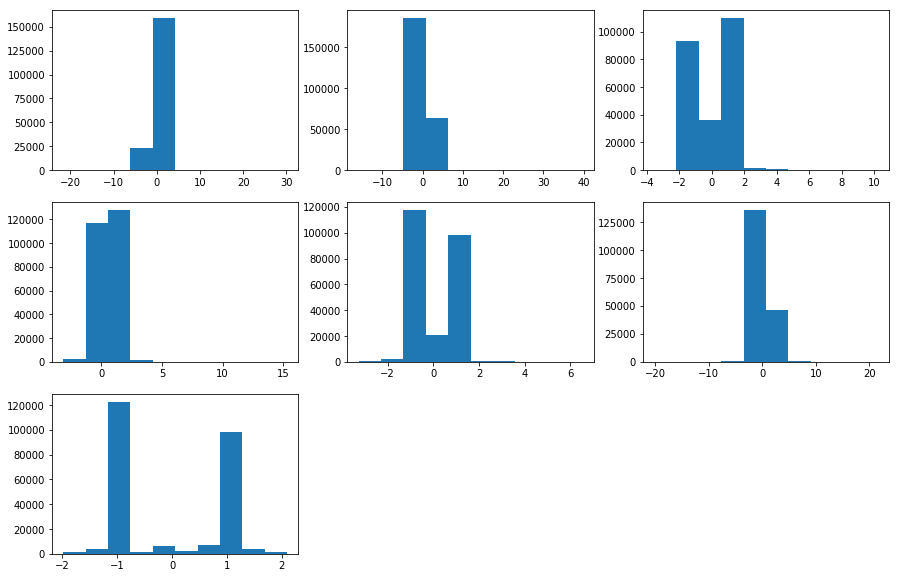

In [74]:
plt.figure(figsize=(15,10))
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.hist(norm_mat[:,:,i+21].flatten())

(array([ 46166.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 203462.]),
 array([0.36787945, 0.43109152, 0.49430355, 0.5575156 , 0.62072766,
        0.6839397 , 0.7471518 , 0.8103638 , 0.87357587, 0.93678796,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

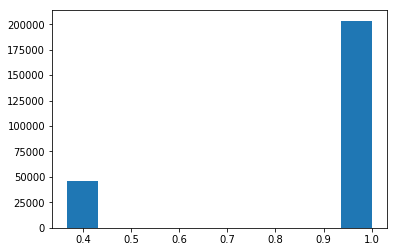

In [29]:
plt.hist(exp_mat[:,:,0].flatten())

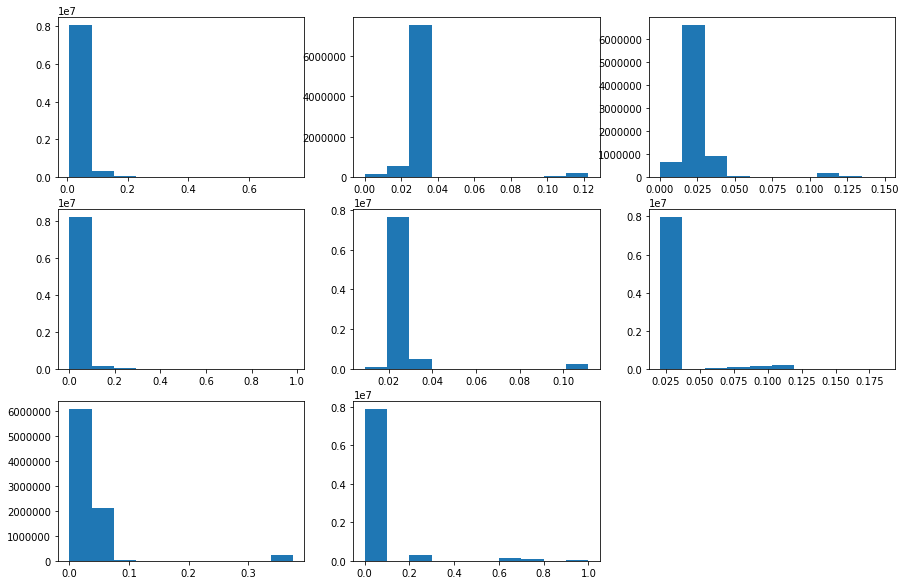

In [172]:
#edge after normalization
plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.hist(tmp11[:,:,:,i-1].flatten())

# Make Sure Test Set index match with node and edge features matrices

In [198]:
# Binary HCV WT
test = pkl.load(open("../ml-cleavage/Data/X_test_HCV_binary_0.3","rb"))
test_name = np.loadtxt("../ml-cleavage/Data/testset_HCV_binary_0.3.txt",dtype='str')

In [ ]:
# Binary HCV WT energy only
test = pkl.load(open("../ml-cleavage/Data/X_test_HCV_binary_0.3","rb"))
test_name = np.loadtxt("../ml-cleavage/Data/testset_HCV_binary_0.3.txt",dtype='str')

In [201]:
test.index.values

array(['YYTIQ', 'YYTHY', 'YYSMN', ..., 'AACGD', 'AAASK', 'PSPVV'],
      dtype=object)

In [202]:
test_name

array(['YYTIQ', 'YYTHY', 'YYSMN', ..., 'AAEEQ', 'AACGD', 'AAASK'],
      dtype='<U5')

In [204]:
test.loc['PSPVV',:]

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,prot,pept,cst,amber
PSPVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.479558,0.508897,0.398558,0.573695
PSPVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.479558,0.508897,0.398558,0.573695


In [ ]:
graph = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.graph","rb"))
x = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.x","rb"))
y = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.y","rb"))
sequences = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.sequences","rb"))
labelorder = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.labelorder","rb"))


In [4]:
input_test = np.loadtxt("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_4_energy_7_energyedge_5_hbond.test.index")

In [243]:
def generate_test_index(dataset_name, test_name): # eg. for test_name: testset_HCV_binary_0.3.txt 
    sequences = pkl.load(open("../data/ind.{}.sequences".format(dataset_name),"rb"))
    if type(test_name) == 'str':
        test_list = np.loadtxt(test_name,dtype="str")
    else:
        test_list = np.asarray(test_name)
    test_ind = [np.where(seqs == test_name[i])[0][0] for i in range(len(test_name))]
    np.savetxt("../data/ind.{}.test.index".format(dataset_name),test_ind, fmt="%d")

In [255]:
generate_test_index("HCV_binary_10_ang_aa_sinusoidal_encoding_4_energy_7_energyedge_5_hbond", test_name)

In [256]:
test_index = np.loadtxt("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_4_energy_7_energyedge_5_hbond.test.index",dtype=int)


In [253]:
test_index

array([   2,    3,    8, ..., 7334, 7338, 7339])

In [257]:
test_index

array([   2,    3,    8, ..., 7334, 7338, 7339])

# Cross Validation code modification

In [31]:
import torch
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp
import os

In [3]:
graph = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.graph","rb"))
x = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.x","rb"))
y = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.y","rb"))
sequences = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.sequences","rb"))
labelorder = pkl.load(open("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond.labelorder","rb"))
input_test = np.loadtxt("../data/ind.HCV_binary_10_ang_aa_sinusoidal_encoding_4_energy_7_energyedge_5_hbond.test.index",dtype=int)

In [32]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [5]:
protease = 'HCV'
names = ['x', 'y', 'graph', 'sequences', 'labelorder']
objects = [x, y, graph, sequences, labelorder]

features, y_arr, adj_ls, sequences, labelorder = tuple(objects)
proteases = [protease for x in sequences]
# turn edges into nodes
# node feature matrix

# Split all datasets into testing, training, and validation. The split of this data is fixed for each dataset
# because the numpy seed is fixed, currently the breakdown is train: 60, validation: 10, test: 30
idx = [y_ind for y_ind in range(y_arr.shape[0])]
np.random.shuffle(idx)
cutoff_1 = int(6*len(idx)/10)
cutoff_2 = int(7*len(idx)/10)
idx_train = idx[:cutoff_1]
idx_val = idx[cutoff_1:cutoff_2]
idx_test = idx[cutoff_2:]
idx_train, idx_val, idx_test = np.sort(idx_train), np.sort(idx_val), np.sort(idx_test)
# make logical indices (they are the size BATCH)
train_mask = sample_mask(idx_train, y_arr.shape[0])
val_mask = sample_mask(idx_val, y_arr.shape[0])
test_mask = sample_mask(idx_test, y_arr.shape[0])

In [6]:
test_idx_reorder = input_test
test_idx_range = np.sort(test_idx_reorder)
test_mask = np.zeros(len(train_mask), dtype=np.bool)
test_mask[test_idx_range] = True
# make train test split
tmp_mask = test_mask.copy()
train_mask = np.array([(not idx) for idx in test_mask],dtype=np.bool)

train_ind = set(range(len(train_mask))) - set(test_idx_range)
val_ind = np.random.choice(list(train_ind), int(len(train_mask)*0.1),replace=False)

val_mask = np.zeros(len(train_mask), dtype=np.bool)
val_mask[val_ind] = True
tmp_mask[val_ind] = True
train_mask = np.array([(not idx) for idx in tmp_mask], dtype=np.bool)


In [7]:
cv = 7
cv_aux = np.array_split(np.where(train_mask == True)[0], cv-1)
train_mask = []
for i in cv_aux:
    train_mask.append(sample_mask(i, y_arr.shape[0]))

In [8]:
train_mask.append(val_mask)

In [9]:
train_mask

[array([ True,  True, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False,  True,  True]),
 array([False, False, False, ..., False, False, False])]

In [51]:
[True for x in train_mask if x == True]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [54]:
np.sum(train_mask[0],axis=0,dtype=bool)

True

In [55]:
train_mask[-1]

array([False,  True, False, ..., False, False, False])

In [60]:
tmp_mask = train_mask.copy()
tmp_mask

[array([ True, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False,  True,  True]),
 array([False,  True, False, ..., False, False, False])]

In [61]:
tmp_mask.pop(0)

array([ True, False, False, ..., False, False, False])

In [62]:
tmp_mask

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False,  True,  True]),
 array([False,  True, False, ..., False, False, False])]

In [63]:
train_mask

[array([ True, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False,  True,  True]),
 array([False,  True, False, ..., False, False, False])]

In [33]:
def load_data(dataset_str, is_test=None, norm_type=False, cv=7):
    protease = dataset_str.replace("protease_","")
    protease = protease.split("_selector")[0]
    cwd = os.getcwd()
    #os.chdir("..")
#    print(cwd)
    names = ['x', 'y', 'graph', 'sequences', 'labelorder']
    objects = []
    for i in range(len(names)):
        with open("../data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    features, y_arr, adj_ls, sequences, labelorder = tuple(objects)
    #os.chdir(cwd)
    proteases = [protease for x in sequences]

    # turn edges into nodes
    # node feature matrix

    # Split all datasets into testing, training, and validation. The split of this data is fixed for each dataset
    # because the numpy seed is fixed, currently the breakdown is train: 60, validation: 10, test: 30
    idx = [y_ind for y_ind in range(y_arr.shape[0])]
    np.random.shuffle(idx)
    cutoff_1 = int((cv-1)*len(idx)/10)
    cutoff_2 = int(cv*len(idx)/10)
    idx_train = idx[:cutoff_1]
    idx_val = idx[cutoff_1:cutoff_2]
    idx_test = idx[cutoff_2:]
    idx_train, idx_val, idx_test = np.sort(idx_train), np.sort(idx_val), np.sort(idx_test)
    # make logical indices (they are the size BATCH)
    train_mask = sample_mask(idx_train, y_arr.shape[0])
    val_mask = sample_mask(idx_val, y_arr.shape[0])
    test_mask = sample_mask(idx_test, y_arr.shape[0])

    if is_test != None:
        test_idx_reorder = parse_index_file("../data/ind.{}.test.index".format(is_test))
        test_idx_range = np.sort(test_idx_reorder)
        test_mask = np.zeros(len(train_mask), dtype=np.bool)
        test_mask[test_idx_range] = True
        # make train test split
        tmp_mask = test_mask.copy()
        train_mask = np.array([(not idx) for idx in test_mask],dtype=np.bool)
        
        train_ind = set(range(len(train_mask))) - set(test_idx_range)
        val_ind = np.random.choice(list(train_ind), int(len(train_mask)*0.1),replace=False)
        
        val_mask = np.zeros(len(train_mask), dtype=np.bool)
        val_mask[val_ind] = True
        tmp_mask[val_ind] = True
        train_mask = np.array([(not idx) for idx in tmp_mask], dtype=np.bool)

    if cv != 0:
        idx = np.where(train_mask == True)[0]
        np.random.shuffle(idx)
        cv_aux = np.array_split(idx, cv-1)
        train_mask = [val_mask]
        for i in cv_aux:
            train_mask.append(sample_mask(i, y_arr.shape[0]))
        #train_mask.append(val_mask)
    else:
        train_mask = [val_mask, train_mask]
#    features, adj_ls = rebuild_mat(features,adj_ls)
#     features = transform(features,ind='(-8,-1)') #only energy features
#     adj_ls = transform(adj_ls, ind='(0,6)') # only energy features

#     adj_ls = normalize(adj_ls)
    
    features = torch.FloatTensor(np.array(features))
    y_arr = torch.LongTensor(y_arr)
    adj_ls = torch.FloatTensor(np.array(adj_ls))

    return adj_ls, features, y_arr, sequences, proteases, labelorder, train_mask, test_mask

In [34]:
adj_ls, features, labels, sequences, proteases, labelorder, train_mask, test_mask = load_data("HCV_binary_10_ang_aa_sinusoidal_encoding_2_energy_7_energyedge_5_hbond", is_test=None, norm_type=False,cv=7)


In [53]:
train_mask

[array([False, False, False, ..., False,  True, False]),
 array([False, False,  True, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([ True, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ...,  True, False, False]),
 array([False, False, False, ..., False, False, False])]

In [55]:
np.sum(train_mask[0])

734

In [56]:
for fold in range(7):
    tmp_mask = train_mask.copy()
    val_mask = tmp_mask.pop(fold)
   
    train_mask_tmp = np.sum(tmp_mask, axis=0, dtype=bool)
    print(val_mask, train_mask_tmp)

[False False False ... False  True False] [ True False  True ...  True False False]
[False False  True ... False False False] [ True False False ...  True  True False]
[False False False ... False False False] [ True False  True ...  True  True False]
[ True False False ... False False False] [False False  True ...  True  True False]
[False False False ... False False False] [ True False  True ...  True  True False]
[False False False ...  True False False] [ True False  True ... False  True False]
[False False False ... False False False] [ True False  True ...  True  True False]


In [59]:
np.sum(train_mask_tmp)

4405

In [12]:
os.chdir('../model/')
from utils import *
from models import GCN

In [13]:
import os
import time
import logging
import argparse
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import scipy.sparse as sp
from torch.nn.parameter import Parameter

In [279]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

In [60]:
# Model and optimizer
model2 = GCN(nnode=features.shape[1],
        nfeat=features.shape[2],
        mfeat=adj_ls.shape[3],
        hidden1=20,
        hidden2=20,
        natt=0, # one layer
        nclass=labels.shape[1],
        dropout=0.01,
        cheby=None)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(),lr=5e-3, weight_decay=0.001)

In [262]:
torch.save({'state_dict': model2.state_dict()}, 'temp.pth')

In [242]:
checkpoint = torch.load('temp.pth')
model2.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [74]:
batch_size = 8
n = 0
checkpoint = torch.load('temp.pth')
model2.load_state_dict(checkpoint['state_dict'])
for batch_mask in get_batch_iterator(train_mask_tmp, batch_size):
            optimizer.zero_grad()
            n = n + 1
            #print('{0}th fold:: this is the {1}th batch'.format(fold+1, n))
            x = features[batch_mask]
            y = labels[batch_mask]
            y = torch.argmax(y,axis=1)
            adj = adj_ls[batch_mask]
            model2.train()
            logits = model2(x, adj)
            loss = criterion(logits,y)
            loss.backward()
            optimizer.step()
            train_acc = accuracy(logits, y)
            break

In [67]:
logits

tensor([[0.5011, 0.4989],
        [0.4824, 0.5176],
        [0.5041, 0.4959],
        [0.4966, 0.5034],
        [0.4989, 0.5011],
        [0.5080, 0.4920],
        [0.5063, 0.4937],
        [0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)

In [68]:
for i in model2.parameters():
    print(i)

Parameter containing:
tensor([[ 0.0044],
        [-0.0039],
        [-0.0045],
        [ 0.0049],
        [ 0.0040],
        [ 0.0049],
        [-0.0046],
        [-0.0045]], requires_grad=True)
Parameter containing:
tensor([0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950],
       requires_grad=True)
Parameter containing:
tensor([-2.0311e-27, -2.3056e-27, -4.3306e-27, -2.1947e-27, -3.3823e-28,
         2.4004e-27, -1.4695e-27,  2.0222e-27,  2.8979e-27, -2.2958e-28,
        -3.1752e-27, -2.8976e-28,  2.0542e-28, -5.0391e-28,  7.9744e-28,
         1.2284e-27,  1.0262e-27, -1.2304e-27, -4.8438e-27, -1.4898e-27,
        -2.3813e-27,  3.9729e-28,  4.8883e-28, -6.7035e-29, -1.6111e-27,
        -7.4755e-28,  5.6809e-28, -2.7275e-27,  1.1976e-27,  2.4

In [75]:
train_acc

tensor(0.3750, dtype=torch.float64)

In [34]:
for i in model2.parameters():
    print(i)

Parameter containing:
tensor([[ 0.0046],
        [ 0.0036],
        [-0.0048],
        [ 0.0049],
        [-0.0001],
        [ 0.0049],
        [-0.0044],
        [-0.0038]], requires_grad=True)
Parameter containing:
tensor([0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950],
       requires_grad=True)
Parameter containing:
tensor([-1.9356e-27, -1.3462e-27, -2.2793e-27, -7.1547e-28, -6.2838e-28,
         1.3622e-27, -9.7388e-28,  1.7539e-27,  1.6475e-27, -4.1556e-29,
        -1.9010e-27, -1.1211e-28,  1.3798e-28, -1.7423e-28,  4.7247e-28,
         7.8928e-28,  6.7909e-28, -7.6033e-28, -2.7938e-27, -4.8002e-28,
        -1.4576e-27,  2.2766e-28,  2.5002e-28,  3.0145e-29, -8.8299e-28,
        -3.6658e-28,  3.5173e-28, -1.4951e-27,  7.6092e-28,  2.1

In [246]:
train_acc

tensor(0.2500, dtype=torch.float64)

In [255]:
val_mask

array([False, False, False, ...,  True,  True, False])

In [256]:
train_mask_tmp

array([ True, False,  True, ..., False, False, False])

In [76]:
with torch.no_grad():
    model2.eval()
    logits_val = model2(features[val_mask], adj_ls[val_mask])
    loss_val = criterion(logits_val,torch.argmax(labels[val_mask],axis=1))
    val_acc = accuracy(logits_val, torch.argmax(labels[val_mask],axis=1))


In [77]:
logits_val

tensor([[0.4481, 0.5519],
        [0.4481, 0.5519],
        [0.4481, 0.5519],
        ...,
        [0.4481, 0.5519],
        [0.4481, 0.5519],
        [0.4484, 0.5516]])

In [72]:
len(val_mask)

7342

In [78]:
val_acc

tensor(0.7466, dtype=torch.float64)

In [208]:
logits_val

tensor([[-0.1618,  0.2166],
        [-0.1618,  0.2166],
        [-0.1621,  0.2167],
        ...,
        [-0.1622,  0.2167],
        [-0.1621,  0.2167],
        [-0.1622,  0.2167]])

# model selection

In [1]:
import os
import time
import logging
import argparse
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import scipy.sparse as sp
from torch.nn.parameter import Parameter

In [17]:
model = GCN_1(nnode=40,
            nfeat=50,
            mfeat=11,
            hidden1=20,
            hidden2=20,
            natt=0, # one layer
            nclass=2,
            dropout=0.01,
            cheby=None)
# criterion = nn.CrossEntropyLoss().to(device)

# optimizer = optim.Adam(model.parameters(),lr=args.lr, weight_decay=args.weight_decay)


In [2]:
os.chdir("../model/")
from layers import *

In [16]:
class GCN_1(nn.Module):
    def __init__(self, nnode, nfeat, mfeat, hidden1, hidden2, natt, nclass, dropout,cheby):
        super(GCN_1, self).__init__()
#        ngcn_list = ngcn.strip('[]').split(',')
#        nfull_list = nfull.strip('[]').split(',')
#        natt_list = natt.strip('[]').split(',')
#        nin = nfeat # in_features
        self.dropout = dropout
        gcn_layers = [] # build a list for gcnn layers
#        if cheby == None:
#            for nhid in ngcn_list:
#                gcn_layers.append(GraphConvolution(nin, int(nhid)))
#                gcn_layers.append(norm(nnode))
#                gcn_layers.append(ConcatReLU())
#                nin = int(nhid)

        #self.norm0 = norm(nnode)
        #self.norm3 = norm(nnode)
        #self.relu3 = ConcatReLU()
#         if cheby == None:
#             self.gcn1 = GraphConvolution(nfeat, hidden1)
#             self.gcn2 = GraphConvolution(hidden1, hidden2)
#             #self.gcn3 = GraphConvolution(hidden2, 20)
#         else:
#             self.gcn1 = GraphConvolutionChebyshev(nfeat, hidden1, cheby)
#             self.gcn2 = GraphConvolutionChebyshev(hidden1, hidden2, cheby)
        nin = nfeat
        for nhid in [20,20]:
            gcn_layers.append(GraphConvolution(nin, int(nhid)))
            gcn_layers.append(norm(nnode,'pre'))
            gcn_layers.append(ConcatReLU())
            nin = int(nhid)
            
#        natt_in = int(ngcn_list[-1])
#        if natt_list != ['']:
#            for nhid in natt_list:
#                gcn_layers.append(SelfAttention(natt_in, nhid))
#                natt_in = nhid
        if natt != 0:
            self.att = SelfAttention(hidden2, natt) # dimension of value keeps the same with input size
            # single head for now
            self.is_att = True
        else:
            self.is_att = False
        self.gc = nn.Sequential(*gcn_layers)
#        self.gc1 = GraphConvolution(nfeat, nhid1)
#        self.gc2 = GraphConvolution(nhid1, nhid2)
#        full_layers = []
#        nin_full = nhid * nnode # in_features for fully connected layers, which is gcn output * number of node
#        for nlinear in nfull_list:
#            if nlinear != '':
#                full_layers.append(ConcatLinear(nin_full, int(nlinear)))
#                nin_full = int(nlinear)
#        full_layers.append(ConcatLinear(nin_full, nclass))
#        self.full = full_layers
        self.flatten = Flatten()
        self.linear = ConcatLinear(hidden2 * nnode, nclass)
        #self.linear0 = ConcatLinear(hidden2 * nnode, 1024)
        #self.linear1 = ConcatLinear(1024, nclass) 
        self.edgeweight = Parameter(torch.FloatTensor(mfeat,1))

    def forward(self, x, adj):
        adj = torch.matmul(adj, self.edgeweight).view(adj.shape[0],adj.shape[1],-1)
        for func in self.gc:
            x = func(x,adj)
        #x = self.norm0(x,adj)
        #x = self.gcn3(x,adj)
        #x = self.norm3(x,adj)
        #x = self.relu3(x,adj)
#         x = self.gcn1(x,adj)
#         x = self.gcn2(x,adj)
        if self.is_att == True:
            x = self.att(x,adj[...,channel])
#         adj = torch.matmul(adj,self.edgeweight).view(adj.shape[0],adj.shape[1],-1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.flatten(x,adj)
        x = self.linear(x,adj)
        #x = self.linear0(x,adj)
        #x = self.linear1(x,adj)
        #x = self.linear2(x,adj)
#        for func_full in self.full:
#            x = func_full(x,adj)
#        x = self.linear2(x,adj)
        return F.softmax(x, dim=1)

In [19]:
adj = torch.randn((734,40,40,11))
tmp=Parameter(torch.FloatTensor(11,1))
# a = torch.matmul(adj, tmp)

In [36]:
a.shape

torch.Size([400, 40, 40, 1])

In [37]:
tmp

Parameter containing:
tensor([[1.8217e-44],
        [-0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.4013e-45],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00]], requires_grad=True)

In [38]:
s = 0
for i in range(0,11):
    s += adj[0,0,0,i] * tmp[i][0]

In [5]:
x = torch.randn(734,40,50)
tmp=torch.randn(734,40,40)
torch.matmul(tmp,x).shape

torch.Size([734, 40, 50])

In [56]:
xx=x.view(x.shape[0],x.shape[1],-1,1)

In [61]:
xx=xx.expand(734,40,50,11)

In [20]:
tmp = model(x,adj)

In [21]:
model

GCN_1(
  (gc): Sequential(
    (0): GraphConvolution (50 -> 20)
    (1): norm(
      (norm): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConcatReLU(
      (relu): ReLU()
    )
    (3): GraphConvolution (20 -> 20)
    (4): norm(
      (norm): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ConcatReLU(
      (relu): ReLU()
    )
  )
  (flatten): Flatten()
  (linear): ConcatLinear(
    (linear): Linear(in_features=800, out_features=2, bias=True)
  )
)

In [66]:
adj_t = torch.transpose(adj, -1,-3)
adj_t = torch.transpose(adj_t, -1,-2)
xx_t = torch.transpose(xx,-1,-3)
xx_t = torch.transpose(xx_t,-1,-2)
support = torch.matmul(adj_t, xx_t)

In [67]:
support.shape

torch.Size([734, 11, 40, 50])

In [70]:
support = torch.transpose(support, -1,-3)
support = torch.transpose(support, -2,-3)
support.shape

torch.Size([734, 40, 50, 11])

In [71]:
t = torch.matmul(support,tmp)
t.shape

torch.Size([734, 40, 50, 1])

In [42]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-3)

In [43]:
y = labels[train_mask[0]]
y = torch.argmax(y,axis=1)

In [44]:
loss = criterion(tmp,y)
loss.backward()
optimizer.step()

In [53]:
t = torch.transpose(adj,-1,-3)

In [54]:
t.shape

torch.Size([734, 11, 40, 40])

In [55]:
tt=torch.matmul(t,x)

RuntimeError: The size of tensor a (11) must match the size of tensor b (734) at non-singleton dimension 1

In [52]:
x.shape

torch.Size([734, 40, 50])

# Generate ternary list for mutants

In [19]:
import os
import numpy as np
import pandas as pd

In [16]:
mutant = '021'
o = 'A171T'
load = []
for f in os.listdir('./'): #../../Rotation_in_Sagar_Lab/Dataset_For_All_Experimental_Sequences/'):
    if f[0:3] == mutant:
        if f != mutant + '_unselected.txt':
            fp = open(f,'r')
            for line in fp:
                load.append(['A' + line.strip() + 'C.ASHL',f.split('_')[-1].split('.')[0]])


In [17]:
load_np = np.asarray(load).reshape(len(load),2)

In [18]:
load_np

array([['ARTYHPC.ASHL', 'middle'],
       ['ASTTEHC.ASHL', 'middle'],
       ['ARTITQC.ASHL', 'middle'],
       ...,
       ['APHPPFC.ASHL', 'uncleaved'],
       ['APHPPTC.ASHL', 'uncleaved'],
       ['APHPPSC.ASHL', 'uncleaved']], dtype='<U12')

In [20]:
df = pd.DataFrame(load_np, columns=['Sequence','Result'])

In [21]:
df.head()

,Sequence,Result
0,ARTYHPC.ASHL,middle
1,ASTTEHC.ASHL,middle
2,ARTITQC.ASHL,middle
3,ADVFQPC.ASHL,middle
4,ASTNHPC.ASHL,middle


In [23]:
df.to_csv('/Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/classifications/HCV_A171T_ternary.txt',sep='\t',index=False)

In [25]:
def generate_classification(mutant_name, path, \
                            out_path='/Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/classifications/',\
                           out_name='class.txt'):
    load = []
    for f in os.listdir(path): #../../Rotation_in_Sagar_Lab/Dataset_For_All_Experimental_Sequences/'):
        if f[0:3] == mutant_name:
            if f != mutant_name + '_unselected.txt':
                fp = open(f,'r')
                for line in fp:
                    load.append(['A' + line.strip() + 'C.ASHL',f.split('_')[-1].split('.')[0]])
    load_np = np.asarray(load).reshape(len(load),2)
    df = pd.DataFrame(load_np, columns=['Sequence','Result'])
    df.to_csv(os.path.join(out_path + out_name),sep='\t',index=False)

In [26]:
generate_classification('011', './',out_name='HCV_Triple_ternary.txt')

In [27]:
generate_classification('091', './',out_name='HCV_D183A_ternary.txt')